<a href="https://colab.research.google.com/github/MinJunJA/babymodel/blob/master/newdata_crnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#crnn3 - 데이터 증강

import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Reshape
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift

# 데이터셋 디렉토리 경로 설정
data_dir = '/content/drive/MyDrive/data2'

# 클래스 레이블 설정 (클래스별 디렉토리 이름으로 가정)
class_labels = os.listdir(data_dir)

# MFCC 계수 개수 설정
n_mfcc = 12

# 데이터셋과 레이블을 저장할 리스트
X = []
labels = []

# 데이터셋 불러오기
for label_idx, label in enumerate(class_labels):
    class_dir = os.path.join(data_dir, label)
    for filename in os.listdir(class_dir):
        file_path = os.path.join(class_dir, filename)
        y, sr = librosa.load(file_path, sr=16000)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        X.append(mfccs.T)
        labels.append(label)

# NumPy 배열로 변환
X = np.array(X)

# 레이블을 정수형으로 인코딩
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
num_classes = len(class_labels)
labels = to_categorical(labels, num_classes=num_classes)

# 최대 길이에 맞춰 MFCC 벡터를 패딩
max_length = max(len(mfccs) for mfccs in X)
X = np.array([np.pad(mfccs, ((0, max_length - len(mfccs)), (0, 0)), mode='constant') for mfccs in X])

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# 데이터 증강 생성기 설정
audio_augmentations = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.01),
    TimeStretch(min_rate=0.8, max_rate=1.25),
    PitchShift(min_semitones=-4, max_semitones=4),
    Shift(min_fraction=-0.2, max_fraction=0.2)
])

# 오디오 데이터 증강 함수
def augment_audio(audio):
    return audio_augmentations(samples=audio, sample_rate=16000)

# 증강된 오디오 데이터 생성
X_train_augmented = np.array([augment_audio(np.transpose(audio)) for audio in X_train])
X_train_augmented = np.array([np.transpose(audio) for audio in X_train_augmented])

# 모델 생성
model = Sequential()

# Convolutional Layer 추가
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())  # BatchNormalization 추가

# Convolutional Layer 추가
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())  # BatchNormalization 추가

# Convolutional Layer 추가
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(BatchNormalization())  # BatchNormalization 추가

model.add(Flatten())

# LSTM 레이어 변경
model.add(Reshape((X_train.shape[1] // 8, (X_train.shape[2] // 8) * 256)))  # Reshape 추가
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dropout(0.5))

# Output 레이어 변경
model.add(Dense(num_classes, activation='softmax'))

# 모델 컴파일
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 학습
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)

# 모델 평가
accuracy = model.evaluate(X_test, y_test)[1]
print("Accuracy:", accuracy)

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=63
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=63
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=63
  warnings.warn(


Epoch 1/100
247/247 [==============================] - 23s 16ms/step - loss: 1.5942 - accuracy: 0.3827 - val_loss: 1.6651 - val_accuracy: 0.3505
Epoch 2/100
247/247 [==============================] - 2s 10ms/step - loss: 1.4355 - accuracy: 0.4571 - val_loss: 1.3217 - val_accuracy: 0.4977
Epoch 3/100
247/247 [==============================] - 3s 14ms/step - loss: 1.3432 - accuracy: 0.4980 - val_loss: 1.2653 - val_accuracy: 0.5240
Epoch 4/100
247/247 [==============================] - 3s 11ms/step - loss: 1.2482 - accuracy: 0.5469 - val_loss: 1.2380 - val_accuracy: 0.5445
Epoch 5/100
247/247 [==============================] - 3s 10ms/step - loss: 1.1524 - accuracy: 0.5860 - val_loss: 1.1414 - val_accuracy: 0.5776
Epoch 6/100
247/247 [==============================] - 2s 10ms/step - loss: 1.0359 - accuracy: 0.6403 - val_loss: 1.1181 - val_accuracy: 0.6119
Epoch 7/100
247/247 [==============================] - 2s 10ms/step - loss: 0.9493 - accuracy: 0.6765 - val_loss: 1.0233 - val_accuracy

In [ ]:
!pip install audiomentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 1.4 MB/s eta 0:00:00


In [ ]:
#CRNN2
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Reshape

# 데이터셋 디렉토리 경로 설정
data_dir = '/content/drive/MyDrive/data2'

# 클래스 레이블 설정 (클래스별 디렉토리 이름으로 가정)
class_labels = os.listdir(data_dir)

# MFCC 계수 개수 설정
n_mfcc = 12

# 데이터셋과 레이블을 저장할 리스트
X = []
labels = []

# 데이터셋 불러오기
for label_idx, label in enumerate(class_labels):
    class_dir = os.path.join(data_dir, label)
    for filename in os.listdir(class_dir):
        file_path = os.path.join(class_dir, filename)
        y, sr = librosa.load(file_path, sr=16000)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        X.append(mfccs.T)
        labels.append(label)

# NumPy 배열로 변환
X = np.array(X)

# 레이블을 정수형으로 인코딩
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
num_classes = len(class_labels)
labels = to_categorical(labels, num_classes=num_classes)

# 최대 길이에 맞춰 MFCC 벡터를 패딩
max_length = max(len(mfccs) for mfccs in X)
X = np.array([np.pad(mfccs, ((0, max_length - len(mfccs)), (0, 0)), mode='constant') for mfccs in X])

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# 모델 생성
model = Sequential()

# Convolutional Layer 추가
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())  # BatchNormalization 추가


# Convolutional Layer 추가
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())  # BatchNormalization 추가

# Convolutional Layer 추가
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(BatchNormalization())  # BatchNormalization 추가

model.add(Flatten())

# LSTM 레이어 변경
model.add(Reshape((X_train.shape[1] // 8, (X_train.shape[2] // 8) * 256)))  # Reshape 추가
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dropout(0.5))

# Output 레이어 변경
model.add(Dense(num_classes, activation='softmax'))

# 모델 컴파일
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 학습
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)

# 모델 평가
accuracy = model.evaluate(X_test, y_test)[1]
print("Accuracy:", accuracy)

Epoch 1/100
247/247 [==============================] - 11s 15ms/step - loss: 1.6055 - accuracy: 0.3626 - val_loss: 1.4459 - val_accuracy: 0.4247
Epoch 2/100
247/247 [==============================] - 3s 14ms/step - loss: 1.4522 - accuracy: 0.4460 - val_loss: 1.3488 - val_accuracy: 0.4977
Epoch 3/100
247/247 [==============================] - 3s 11ms/step - loss: 1.3592 - accuracy: 0.4949 - val_loss: 1.2937 - val_accuracy: 0.5171
Epoch 4/100
247/247 [==============================] - 3s 12ms/step - loss: 1.2503 - accuracy: 0.5463 - val_loss: 1.2009 - val_accuracy: 0.5559
Epoch 5/100
247/247 [==============================] - 3s 13ms/step - loss: 1.1690 - accuracy: 0.5814 - val_loss: 1.1799 - val_accuracy: 0.5708
Epoch 6/100
247/247 [==============================] - 3s 12ms/step - loss: 1.0632 - accuracy: 0.6301 - val_loss: 1.1272 - val_accuracy: 0.5811
Epoch 7/100
247/247 [==============================] - 3s 13ms/step - loss: 0.9784 - accuracy: 0.6662 - val_loss: 1.0622 - val_accuracy

In [ ]:
#dropout 추가

#CRNN
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Reshape

# 데이터셋 디렉토리 경로 설정
data_dir = '/content/drive/MyDrive/data2'

# 클래스 레이블 설정 (클래스별 디렉토리 이름으로 가정)
class_labels = os.listdir(data_dir)

# MFCC 계수 개수 설정
n_mfcc = 12

# 데이터셋과 레이블을 저장할 리스트
X = []
labels = []

# 데이터셋 불러오기
for label_idx, label in enumerate(class_labels):
    class_dir = os.path.join(data_dir, label)
    for filename in os.listdir(class_dir):
        file_path = os.path.join(class_dir, filename)
        y, sr = librosa.load(file_path, sr=16000)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        X.append(mfccs.T)
        labels.append(label)

# NumPy 배열로 변환
X = np.array(X)

# 레이블을 정수형으로 인코딩
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
num_classes = len(class_labels)
labels = to_categorical(labels, num_classes=num_classes)

# 최대 길이에 맞춰 MFCC 벡터를 패딩
max_length = max(len(mfccs) for mfccs in X)
X = np.array([np.pad(mfccs, ((0, max_length - len(mfccs)), (0, 0)), mode='constant') for mfccs in X])

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# 모델 생성
model = Sequential()

# Convolutional Layer 추가
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))  # Dropout 추가

# Convolutional Layer 추가
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))  # Dropout 추가

# Convolutional Layer 추가
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))  # Dropout 추가

model.add(Flatten())

# LSTM 레이어 변경
model.add(Reshape((X_train.shape[1] // 8, (X_train.shape[2] // 8) * 256)))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dropout(0.5))

# Output 레이어 변경
model.add(Dense(num_classes, activation='softmax'))

# 모델 컴파일
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 학습
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)

# 모델 평가
accuracy = model.evaluate(X_test, y_test)[1]
print("Accuracy:", accuracy)

Epoch 1/100
247/247 [==============================] - 23s 16ms/step - loss: 1.6196 - accuracy: 0.3493 - val_loss: 1.4711 - val_accuracy: 0.4361
Epoch 2/100
247/247 [==============================] - 4s 15ms/step - loss: 1.4969 - accuracy: 0.4121 - val_loss: 1.4166 - val_accuracy: 0.4635
Epoch 3/100
247/247 [==============================] - 3s 12ms/step - loss: 1.4234 - accuracy: 0.4490 - val_loss: 1.3223 - val_accuracy: 0.4909
Epoch 4/100
247/247 [==============================] - 3s 11ms/step - loss: 1.3635 - accuracy: 0.4870 - val_loss: 1.2268 - val_accuracy: 0.5320
Epoch 5/100
247/247 [==============================] - 3s 11ms/step - loss: 1.3045 - accuracy: 0.5130 - val_loss: 1.2204 - val_accuracy: 0.5400
Epoch 6/100
247/247 [==============================] - 3s 11ms/step - loss: 1.2382 - accuracy: 0.5389 - val_loss: 1.1951 - val_accuracy: 0.5639
Epoch 7/100
247/247 [==============================] - 3s 14ms/step - loss: 1.1955 - accuracy: 0.5593 - val_loss: 1.1253 - val_accuracy

In [ ]:
#dropout 추가

#CRNN
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Reshape

# 데이터셋 디렉토리 경로 설정
data_dir = '/content/drive/MyDrive/data2'

# 클래스 레이블 설정 (클래스별 디렉토리 이름으로 가정)
class_labels = os.listdir(data_dir)

# MFCC 계수 개수 설정
n_mfcc = 12

# 데이터셋과 레이블을 저장할 리스트
X = []
labels = []

# 데이터셋 불러오기
for label_idx, label in enumerate(class_labels):
    class_dir = os.path.join(data_dir, label)
    for filename in os.listdir(class_dir):
        file_path = os.path.join(class_dir, filename)
        y, sr = librosa.load(file_path, sr=16000)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        X.append(mfccs.T)
        labels.append(label)

# NumPy 배열로 변환
X = np.array(X)

# 레이블을 정수형으로 인코딩
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
num_classes = len(class_labels)
labels = to_categorical(labels, num_classes=num_classes)

# 최대 길이에 맞춰 MFCC 벡터를 패딩
max_length = max(len(mfccs) for mfccs in X)
X = np.array([np.pad(mfccs, ((0, max_length - len(mfccs)), (0, 0)), mode='constant') for mfccs in X])

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# 모델 생성
model = Sequential()

# Convolutional Layer 추가
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))  # Dropout 추가

# Convolutional Layer 추가
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))  # Dropout 추가

# Convolutional Layer 추가
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))  # Dropout 추가

model.add(Flatten())

# LSTM 레이어 변경
model.add(Reshape((X_train.shape[1] // 8, (X_train.shape[2] // 8) * 256)))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dropout(0.5))

# Output 레이어 변경
model.add(Dense(num_classes, activation='softmax'))

# 모델 컴파일
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# 모델 학습
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)

# 모델 평가
accuracy = model.evaluate(X_test, y_test)[1]
print("Accuracy:", accuracy)

Epoch 1/100
247/247 [==============================] - 10s 16ms/step - loss: 1.8781 - accuracy: 0.2480 - val_loss: 1.7806 - val_accuracy: 0.3139
Epoch 2/100
247/247 [==============================] - 3s 11ms/step - loss: 1.7839 - accuracy: 0.2838 - val_loss: 1.6892 - val_accuracy: 0.3265
Epoch 3/100
247/247 [==============================] - 3s 14ms/step - loss: 1.7233 - accuracy: 0.3131 - val_loss: 1.6339 - val_accuracy: 0.3402
Epoch 4/100
247/247 [==============================] - 3s 11ms/step - loss: 1.6753 - accuracy: 0.3388 - val_loss: 1.5901 - val_accuracy: 0.3676
Epoch 5/100
247/247 [==============================] - 3s 10ms/step - loss: 1.6380 - accuracy: 0.3550 - val_loss: 1.5590 - val_accuracy: 0.3836
Epoch 6/100
247/247 [==============================] - 3s 10ms/step - loss: 1.6088 - accuracy: 0.3593 - val_loss: 1.5490 - val_accuracy: 0.3813
Epoch 7/100
247/247 [==============================] - 3s 10ms/step - loss: 1.5845 - accuracy: 0.3719 - val_loss: 1.5330 - val_accuracy

Epoch 1/100
247/247 [==============================] - 14s 10ms/step - loss: 2.2232 - accuracy: 0.1742 - val_loss: 1.9257 - val_accuracy: 0.1861
Epoch 2/100
247/247 [==============================] - 2s 9ms/step - loss: 1.8411 - accuracy: 0.2631 - val_loss: 1.8473 - val_accuracy: 0.2888
Epoch 3/100
247/247 [==============================] - 2s 8ms/step - loss: 1.6538 - accuracy: 0.3685 - val_loss: 1.7376 - val_accuracy: 0.3630
Epoch 4/100
247/247 [==============================] - 2s 7ms/step - loss: 1.3341 - accuracy: 0.5196 - val_loss: 1.6592 - val_accuracy: 0.4361
Epoch 5/100
247/247 [==============================] - 2s 8ms/step - loss: 0.9763 - accuracy: 0.6769 - val_loss: 1.7054 - val_accuracy: 0.4966
Epoch 6/100
247/247 [==============================] - 2s 7ms/step - loss: 0.7300 - accuracy: 0.7774 - val_loss: 1.8253 - val_accuracy: 0.5468
Epoch 7/100
247/247 [==============================] - 2s 7ms/step - loss: 0.5321 - accuracy: 0.8393 - val_loss: 2.0020 - val_accuracy: 0.57

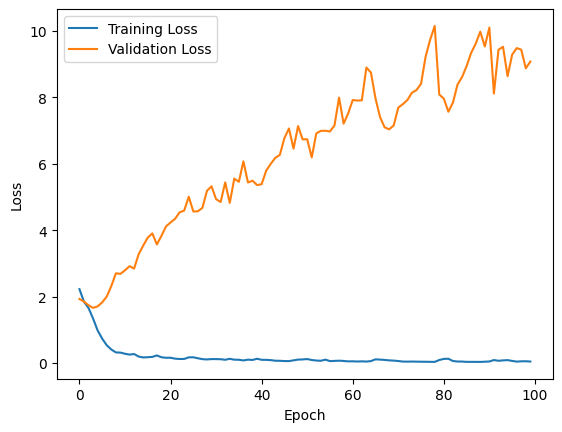

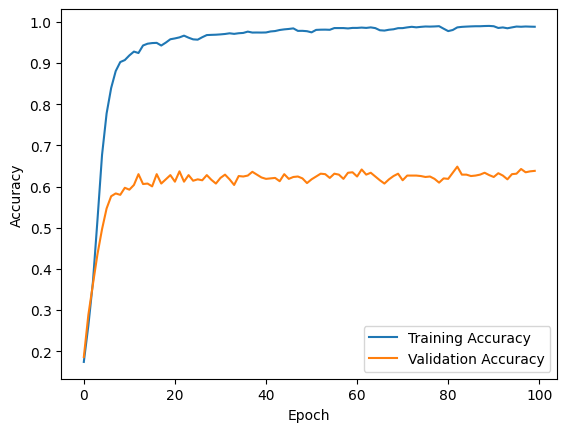

69/69 [==============================] - 0s 5ms/step - loss: 11.9616 - accuracy: 0.6254
Test Loss: 11.9616
Test Accuracy: 0.6254


In [ ]:
import os
import numpy as np
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# 데이터 폴더 경로
data_path = '/content/drive/MyDrive/data2'

# 수정된 분류 레이블
labels = ['awake', 'diaper', 'hug', 'hungry', 'sad', 'sleepy', 'uncomfortable']

# 데이터 및 레이블 저장을 위한 리스트
data = []
target = []

# 각 분류별로 멜 스펙트로그램 생성 및 데이터 수집
for label in labels:
    label_path = os.path.join(data_path, label)
    for filename in os.listdir(label_path):
        if filename.endswith('.wav'):
            file_path = os.path.join(label_path, filename)

            # 오디오 파일 로드 및 멜 스펙트로그램 생성
            y, sr = librosa.load(file_path)
            mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)

            # 멜 스펙트로그램 크기 조정
            mel_spectrogram = mel_spectrogram[:, :128]

            # 데이터 및 레이블 추가
            data.append(mel_spectrogram)
            target.append(label)

# 데이터 전처리
data = np.array(data)
encoder = LabelEncoder()
target = encoder.fit_transform(target)
target = tf.keras.utils.to_categorical(target)

# 훈련 및 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# 모델 설계
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(mel_spectrogram.shape[0], mel_spectrogram.shape[1])),
    tf.keras.layers.Reshape((mel_spectrogram.shape[0], mel_spectrogram.shape[1], 1)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(labels), activation='softmax')
])

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=1)

# 학습 과정 시각화
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 모델 평가
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


In [2]:
#dropout 추가
#CRNN
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Reshape
import tensorflow as tf

# 데이터셋 디렉토리 경로 설정
data_dir = '/content/drive/MyDrive/data2'

# 클래스 레이블 설정 (클래스별 디렉토리 이름으로 가정)
class_labels = os.listdir(data_dir)

# MFCC 계수 개수 설정
n_mfcc = 12

# 데이터셋과 레이블을 저장할 리스트
X = []
labels = []

# 데이터셋 불러오기
for label_idx, label in enumerate(class_labels):
    class_dir = os.path.join(data_dir, label)
    for filename in os.listdir(class_dir):
        file_path = os.path.join(class_dir, filename)
        y, sr = librosa.load(file_path, sr=16000)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        X.append(mfccs.T)
        labels.append(label)

# NumPy 배열로 변환
X = np.array(X)

# 레이블을 정수형으로 인코딩
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
num_classes = len(class_labels)
labels = to_categorical(labels, num_classes=num_classes)

# 최대 길이에 맞춰 MFCC 벡터를 패딩
max_length = max(len(mfccs) for mfccs in X)
X = np.array([np.pad(mfccs, ((0, max_length - len(mfccs)), (0, 0)), mode='constant') for mfccs in X])

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# 모델 생성
model = Sequential()

# Convolutional Layer 추가
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))  # Dropout 추가

# Convolutional Layer 추가
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))  # Dropout 추가

# Convolutional Layer 추가
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))  # Dropout 추가

model.add(Flatten())

# LSTM 레이어 변경
model.add(Reshape((X_train.shape[1] // 8, (X_train.shape[2] // 8) * 256)))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dropout(0.5))

# Output 레이어 변경
model.add(Dense(num_classes, activation='softmax'))

# 모델 컴파일
initial_lr = 0.001  # 초기 학습률 설정

# Learning Rate를 조정할 함수 정의
def lr_schedule(epoch):
    decay_rate = 0.9   # 학습률 감소 비율
    decay_steps = 10    # 학습률 감소 주기 (에폭 단위)
    lr = initial_lr * decay_rate**(epoch // decay_steps)
    return lr

# Learning Rate Scheduler 콜백 생성
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

# 모델 컴파일
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 학습 (Learning Rate Scheduler 콜백 추가)
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[lr_scheduler])

# 모델 평가
accuracy = model.evaluate(X_test, y_test)[1]
print("Accuracy:", accuracy)

Epoch 1/100
247/247 [==============================] - 25s 23ms/step - loss: 1.6272 - accuracy: 0.3498 - val_loss: 1.6423 - val_accuracy: 0.3767 - lr: 0.0010
Epoch 2/100
247/247 [==============================] - 3s 13ms/step - loss: 1.5131 - accuracy: 0.4058 - val_loss: 1.4114 - val_accuracy: 0.4406 - lr: 0.0010
Epoch 3/100
247/247 [==============================] - 3s 12ms/step - loss: 1.4364 - accuracy: 0.4497 - val_loss: 1.3356 - val_accuracy: 0.4783 - lr: 0.0010
Epoch 4/100
247/247 [==============================] - 3s 12ms/step - loss: 1.3731 - accuracy: 0.4839 - val_loss: 1.3033 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/100
247/247 [==============================] - 3s 13ms/step - loss: 1.3130 - accuracy: 0.5103 - val_loss: 1.2252 - val_accuracy: 0.5434 - lr: 0.0010
Epoch 6/100
247/247 [==============================] - 4s 16ms/step - loss: 1.2637 - accuracy: 0.5340 - val_loss: 1.1691 - val_accuracy: 0.5719 - lr: 0.0010
Epoch 7/100
247/247 [==============================] - 3s

In [5]:
#데이터 증강을 넣은 버전
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Reshape
import tensorflow as tf
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Gain

# 데이터셋 디렉토리 경로 설정
data_dir = '/content/drive/MyDrive/data2'

# 클래스 레이블 설정 (클래스별 디렉토리 이름으로 가정)
class_labels = os.listdir(data_dir)

# MFCC 계수 개수 설정
n_mfcc = 12

# 데이터셋과 레이블을 저장할 리스트
X = []
labels = []

# 데이터셋 불러오기
for label_idx, label in enumerate(class_labels):
    class_dir = os.path.join(data_dir, label)
    for filename in os.listdir(class_dir):
        file_path = os.path.join(class_dir, filename)
        y, sr = librosa.load(file_path, sr=16000)

        # 데이터 증강을 위한 변환 적용
        transform = Compose([
            AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015),
            TimeStretch(min_rate=0.8, max_rate=1.2),
            PitchShift(min_semitones=-4, max_semitones=4),
            Gain(min_gain_in_db=-6, max_gain_in_db=6)
        ])
        y_augmented = transform(samples=y, sample_rate=sr)

        # 증강된 음성 데이터로 MFCC 계산
        mfccs = librosa.feature.mfcc(y=y_augmented, sr=sr, n_mfcc=n_mfcc)

        X.append(mfccs.T)
        labels.append(label)

# NumPy 배열로 변환
X = np.array(X)

# 레이블을 정수형으로 인코딩
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
num_classes = len(class_labels)
labels = to_categorical(labels, num_classes=num_classes)

# 최대 길이에 맞춰 MFCC 벡터를 패딩
max_length = max(len(mfccs) for mfccs in X)
X = np.array([np.pad(mfccs, ((0, max_length - len(mfccs)), (0, 0)), mode='constant') for mfccs in X])

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# 모델 생성
model = Sequential()

# Convolutional Layer 추가
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))  # Dropout 추가

# Convolutional Layer 추가
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))  # Dropout 추가

# Convolutional Layer 추가
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))  # Dropout 추가

model.add(Flatten())

# LSTM 레이어 변경
model.add(Reshape((X_train.shape[1] // 8, (X_train.shape[2] // 8) * 256)))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dropout(0.5))

# Output 레이어 변경
model.add(Dense(num_classes, activation='softmax'))

# 모델 컴파일
initial_lr = 0.001  # 초기 학습률 설정

# Learning Rate를 조정할 함수 정의
def lr_schedule(epoch):
    decay_rate = 0.9   # 학습률 감소 비율
    decay_steps = 10    # 학습률 감소 주기 (에폭 단위)
    lr = initial_lr * decay_rate**(epoch // decay_steps)
    return lr

# Learning Rate Scheduler 콜백 생성
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

# 모델 컴파일
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 학습 (Learning Rate Scheduler 콜백 추가)
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[lr_scheduler])

# 모델 평가
accuracy = model.evaluate(X_test, y_test)[1]
print("Accuracy:", accuracy)

Epoch 1/100
247/247 [==============================] - 12s 18ms/step - loss: 1.8278 - accuracy: 0.2454 - val_loss: 1.7378 - val_accuracy: 0.3048 - lr: 0.0010
Epoch 2/100
247/247 [==============================] - 4s 15ms/step - loss: 1.7398 - accuracy: 0.2930 - val_loss: 1.7183 - val_accuracy: 0.2968 - lr: 0.0010
Epoch 3/100
247/247 [==============================] - 3s 12ms/step - loss: 1.7031 - accuracy: 0.3195 - val_loss: 1.6376 - val_accuracy: 0.3345 - lr: 0.0010
Epoch 4/100
247/247 [==============================] - 3s 12ms/step - loss: 1.6726 - accuracy: 0.3360 - val_loss: 1.6600 - val_accuracy: 0.3208 - lr: 0.0010
Epoch 5/100
247/247 [==============================] - 3s 12ms/step - loss: 1.6517 - accuracy: 0.3473 - val_loss: 1.6143 - val_accuracy: 0.3573 - lr: 0.0010
Epoch 6/100
247/247 [==============================] - 4s 16ms/step - loss: 1.6173 - accuracy: 0.3578 - val_loss: 1.6102 - val_accuracy: 0.3642 - lr: 0.0010
Epoch 7/100
247/247 [==============================] - 3s

In [4]:
!pip install audiomentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 553.5 kB/s eta 0:00:00


In [9]:
#dropout 추가
#CRNN
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Reshape
import tensorflow as tf

# 데이터셋 디렉토리 경로 설정
data_dir = '/content/drive/MyDrive/data2'

# 클래스 레이블 설정 (클래스별 디렉토리 이름으로 가정)
class_labels = os.listdir(data_dir)

# MFCC 계수 개수 설정
n_mfcc = 12

# 데이터셋과 레이블을 저장할 리스트
X = []
labels = []

# 데이터셋 불러오기
for label_idx, label in enumerate(class_labels):
    class_dir = os.path.join(data_dir, label)
    for filename in os.listdir(class_dir):
        file_path = os.path.join(class_dir, filename)
        y, sr = librosa.load(file_path, sr=16000)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        X.append(mfccs.T)
        labels.append(label)

# NumPy 배열로 변환
X = np.array(X)

# 레이블을 정수형으로 인코딩
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
num_classes = len(class_labels)
labels = to_categorical(labels, num_classes=num_classes)

# 최대 길이에 맞춰 MFCC 벡터를 패딩
max_length = max(len(mfccs) for mfccs in X)
X = np.array([np.pad(mfccs, ((0, max_length - len(mfccs)), (0, 0)), mode='constant') for mfccs in X])

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# 모델 생성
model = Sequential()

# Convolutional Layer 추가
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))  # Dropout 추가

# Convolutional Layer 추가
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))  # Dropout 추가

# Convolutional Layer 추가
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))  # Dropout 추가

model.add(Flatten())

# LSTM 레이어 변경
model.add(Reshape((X_train.shape[1] // 8, (X_train.shape[2] // 8) * 256)))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dropout(0.5))

# Output 레이어 변경
model.add(Dense(num_classes, activation='softmax'))

# 모델 컴파일
initial_lr = 0.002  # 초기 학습률 설정

# Learning Rate를 조정할 함수 정의
def lr_schedule(epoch):
    decay_rate = 0.9   # 학습률 감소 비율
    decay_steps = 10    # 학습률 감소 주기 (에폭 단위)
    lr = initial_lr * decay_rate**(epoch // decay_steps)
    return lr

# Learning Rate Scheduler 콜백 생성
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

# 모델 컴파일
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 학습 (Learning Rate Scheduler 콜백 추가)
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[lr_scheduler])

# 모델 평가
accuracy = model.evaluate(X_test, y_test)[1]
print("Accuracy:", accuracy)

Epoch 1/100
247/247 [==============================] - 20s 20ms/step - loss: 1.6291 - accuracy: 0.3419 - val_loss: 1.5847 - val_accuracy: 0.3881 - lr: 0.0020
Epoch 2/100
247/247 [==============================] - 3s 12ms/step - loss: 1.5148 - accuracy: 0.4073 - val_loss: 1.4340 - val_accuracy: 0.4463 - lr: 0.0020
Epoch 3/100
247/247 [==============================] - 4s 15ms/step - loss: 1.4437 - accuracy: 0.4449 - val_loss: 1.3351 - val_accuracy: 0.4863 - lr: 0.0020
Epoch 4/100
247/247 [==============================] - 4s 15ms/step - loss: 1.3807 - accuracy: 0.4821 - val_loss: 1.3538 - val_accuracy: 0.4840 - lr: 0.0020
Epoch 5/100
247/247 [==============================] - 3s 12ms/step - loss: 1.3300 - accuracy: 0.4971 - val_loss: 1.2666 - val_accuracy: 0.5114 - lr: 0.0020
Epoch 6/100
247/247 [==============================] - 3s 12ms/step - loss: 1.2902 - accuracy: 0.5166 - val_loss: 1.2315 - val_accuracy: 0.5388 - lr: 0.0020
Epoch 7/100
247/247 [==============================] - 3s

In [10]:
#dropout 추가
#CRNN
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Reshape
import tensorflow as tf

# 데이터셋 디렉토리 경로 설정
data_dir = '/content/drive/MyDrive/data2'

# 클래스 레이블 설정 (클래스별 디렉토리 이름으로 가정)
class_labels = os.listdir(data_dir)

# MFCC 계수 개수 설정
n_mfcc = 12

# 데이터셋과 레이블을 저장할 리스트
X = []
labels = []

# 데이터셋 불러오기
for label_idx, label in enumerate(class_labels):
    class_dir = os.path.join(data_dir, label)
    for filename in os.listdir(class_dir):
        file_path = os.path.join(class_dir, filename)
        y, sr = librosa.load(file_path, sr=16000)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        X.append(mfccs.T)
        labels.append(label)

# NumPy 배열로 변환
X = np.array(X)

# 레이블을 정수형으로 인코딩
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
num_classes = len(class_labels)
labels = to_categorical(labels, num_classes=num_classes)

# 최대 길이에 맞춰 MFCC 벡터를 패딩
max_length = max(len(mfccs) for mfccs in X)
X = np.array([np.pad(mfccs, ((0, max_length - len(mfccs)), (0, 0)), mode='constant') for mfccs in X])

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# 모델 생성
model = Sequential()

# Convolutional Layer 추가
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))  # Dropout 추가

# Convolutional Layer 추가
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))  # Dropout 추가

# Convolutional Layer 추가
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.4))  # Dropout 추가

model.add(Flatten())

# LSTM 레이어 변경
model.add(Reshape((X_train.shape[1] // 8, (X_train.shape[2] // 8) * 256)))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dropout(0.5))

# Output 레이어 변경
model.add(Dense(num_classes, activation='softmax'))

# 모델 컴파일
initial_lr = 0.002  # 초기 학습률 설정

# Learning Rate를 조정할 함수 정의
def lr_schedule(epoch):
    decay_rate = 0.9   # 학습률 감소 비율
    decay_steps = 10    # 학습률 감소 주기 (에폭 단위)
    lr = initial_lr * decay_rate**(epoch // decay_steps)
    return lr

# Learning Rate Scheduler 콜백 생성
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

# 모델 컴파일
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 학습 (Learning Rate Scheduler 콜백 추가)
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[lr_scheduler])

# 모델 평가
accuracy = model.evaluate(X_test, y_test)[1]
print("Accuracy:", accuracy)

Epoch 1/100
247/247 [==============================] - 12s 16ms/step - loss: 1.6401 - accuracy: 0.3462 - val_loss: 1.5667 - val_accuracy: 0.3584 - lr: 0.0020
Epoch 2/100
247/247 [==============================] - 4s 15ms/step - loss: 1.5318 - accuracy: 0.3959 - val_loss: 1.4496 - val_accuracy: 0.4372 - lr: 0.0020
Epoch 3/100
247/247 [==============================] - 4s 14ms/step - loss: 1.4614 - accuracy: 0.4299 - val_loss: 1.3819 - val_accuracy: 0.4578 - lr: 0.0020
Epoch 4/100
247/247 [==============================] - 3s 12ms/step - loss: 1.4239 - accuracy: 0.4603 - val_loss: 1.3533 - val_accuracy: 0.4669 - lr: 0.0020
Epoch 5/100
247/247 [==============================] - 3s 12ms/step - loss: 1.3886 - accuracy: 0.4744 - val_loss: 1.2916 - val_accuracy: 0.5331 - lr: 0.0020
Epoch 6/100
247/247 [==============================] - 3s 13ms/step - loss: 1.3558 - accuracy: 0.4887 - val_loss: 1.3193 - val_accuracy: 0.5091 - lr: 0.0020
Epoch 7/100
247/247 [==============================] - 5s

In [2]:
#dropout 추가
#CRNN
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Reshape
import tensorflow as tf

# 데이터셋 디렉토리 경로 설정
data_dir = '/content/drive/MyDrive/data2'

# 클래스 레이블 설정 (클래스별 디렉토리 이름으로 가정)
class_labels = os.listdir(data_dir)

# MFCC 계수 개수 설정
n_mfcc = 12

# 데이터셋과 레이블을 저장할 리스트
X = []
labels = []

# 데이터셋 불러오기
for label_idx, label in enumerate(class_labels):
    class_dir = os.path.join(data_dir, label)
    for filename in os.listdir(class_dir):
        file_path = os.path.join(class_dir, filename)
        y, sr = librosa.load(file_path, sr=16000)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        X.append(mfccs.T)
        labels.append(label)

# NumPy 배열로 변환
X = np.array(X)

# 레이블을 정수형으로 인코딩
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
num_classes = len(class_labels)
labels = to_categorical(labels, num_classes=num_classes)

# 최대 길이에 맞춰 MFCC 벡터를 패딩
max_length = max(len(mfccs) for mfccs in X)
X = np.array([np.pad(mfccs, ((0, max_length - len(mfccs)), (0, 0)), mode='constant') for mfccs in X])

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# 모델 생성
model = Sequential()

# Convolutional Layer 추가
model.add(Conv2D(128, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)))
model.add(Conv2D(128, (3, 3), activation='relu'))  # 추가된 Conv2D 레이어
model.add(MaxPooling2D((2, 2)))  # 스트라이드 기본값인 (2, 2)로 유지
model.add(BatchNormalization())
model.add(Dropout(0.4))  # Dropout 비율 높임

# Convolutional Layer 추가
model.add(Conv2D(256, (3, 3), activation='relu',padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu',padding='same'))  # 추가된 Conv2D 레이어
model.add(MaxPooling2D((2, 2)))  # 스트라이드 기본값인 (2, 2)로 유지
model.add(BatchNormalization())
model.add(Dropout(0.4))  # Dropout 비율 높임

# Convolutional Layer 추가
model.add(Conv2D(512, (3, 3), activation='relu',padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu',padding='same'))  # 추가된 Conv2D 레이어
model.add(MaxPooling2D((2, 2)))  # 스트라이드 기본값인 (2, 2)로 유지
model.add(BatchNormalization())
model.add(Dropout(0.4))  # Dropout 비율 높임

# Convolutional Layer 추가
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((1, 2)))  # 스트라이드를 (1, 2)로 변경
model.add(BatchNormalization())
model.add(Dropout(0.4))  # Dropout 비율 높임

model.add(Flatten())

# LSTM 레이어 변경 (예시로 하나의 LSTM 레이어만 사용)
model.add(Reshape((X_train.shape[1] // 16, (X_train.shape[2] // 16) * 256)))  # 수정된 부분
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dropout(0.5))

# Output 레이어 변경
model.add(Dense(num_classes, activation='softmax'))

# 모델 컴파일
initial_lr = 0.001  # 초기 학습률 설정

# Learning Rate를 조정할 함수 정의
def lr_schedule(epoch):
    decay_rate = 0.9   # 학습률 감소 비율
    decay_steps = 10    # 학습률 감소 주기 (에폭 단위)
    lr = initial_lr * decay_rate**(epoch // decay_steps)
    return lr

# Learning Rate Scheduler 콜백 생성
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

# 모델 컴파일
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 학습 (Learning Rate Scheduler 콜백 추가)
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[lr_scheduler])

# 모델 평가
accuracy = model.evaluate(X_test, y_test)[1]
print("Accuracy:", accuracy)

ValueError: ignored